<a href="https://colab.research.google.com/github/Kaunaz/Assets/blob/master/notebooks/Attention_ResUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import random
import gdown
import shutil
from multiprocessing import Pool

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import plotly.graph_objs as go
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import v2
from torchvision import models


# try:
#     from neuralop.models import FNO
# except:
#     !pip install -q neuraloperator wandb torch_harmonics
#     from neuralop.models import FNO, UNO

# try:
#     from pytorch_msssim import ssim
# except:
#     !pip install -q pytorch_msssim
#     from pytorch_msssim import ssim

try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary

In [2]:
MODELS_PATH = 'models'
DATASET_PATH = 'small_dataset' # 'dataset' in VM
Path(MODELS_PATH).mkdir(parents=True, exist_ok=True)
RANDOM_SEED = 1
EPOCHS = 50
BATCH_SIZE = 32
MODEL_NAME = 'Attention_resUnetW'
CHECKPOINT_STEP = 5
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

DEBUG = False

PROCESSES = 32

In [3]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

if DEBUG:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Dataset

## Download Dataset

In [4]:
# small: 1Fiqy5bkIp1HD8NKjiQaME-2QSFzO7lDF
# 1: 1gbShLIyAdS2hYrSVWsNrhekL1PgqxWA2

data_zip = 'small_dataset.tar.gz'

if Path(data_zip).is_file():
    print("File already exists.")
else:
    import gdown

    file_id = '1Fiqy5bkIp1HD8NKjiQaME-2QSFzO7lDF'
    url = f'https://drive.google.com/uc?id={file_id}'

    gdown.download(url, data_zip, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Fiqy5bkIp1HD8NKjiQaME-2QSFzO7lDF
From (redirected): https://drive.google.com/uc?id=1Fiqy5bkIp1HD8NKjiQaME-2QSFzO7lDF&confirm=t&uuid=b9c97467-0728-40b9-a25f-b3170568f724
To: /content/small_dataset.tar.gz
100%|██████████| 798M/798M [00:14<00:00, 55.0MB/s]


In [5]:
!tar -xf small_dataset.tar.gz

In [6]:
epsilon_filepath = os.path.join(DATASET_PATH, 'EPSILON', '00001_00001.npy')
kappa_filepath = os.path.join(DATASET_PATH, 'KAPPA', '00001_00001.npy')

In [7]:
epsilon_data = np.load(epsilon_filepath)
kappa_data = np.load(kappa_filepath)
epsilon_data.shape, kappa_data.shape

((3, 128, 128), (128, 128))

## Dataset Utils

In [8]:
def filenames_per_map(folder, idx):
    idx_str = f"{idx:05d}"
    filenames = []

    for filename in os.listdir(folder):
        primera_parte, _ = filename.split('_')
        if primera_parte == idx_str:
            filenames.append(filename)

    return filenames


def maps(folder):
    filenames = os.listdir(folder)
    number_maps = [filename.split('_')[0] for filename in filenames]
    number_maps = map(int, number_maps)
    number_maps = sorted(list(set(number_maps)))
    return number_maps


def calculate_outliers(path, tol=2):
    image = np.load(path)

    max_val = np.max(image)
    min_val = np.min(image)

    if abs(min_val) > 2 or abs(max_val) > 2:
        return path


def calculate_outliers_dataset(folder_path, tol=2, filesave=False):
    os.listdir(folder_path)
    with Pool(PROCESSES) as pool:
        results = pool.starmap(calculate_outliers, [(os.path.join(folder_path, filename), tol) for filename in os.listdir(folder_path)])
    results =  [os.path.basename(result) for result in results if result is not None]

    if filesave:
        with open('outliers.txt', 'w') as f:
            for item in results:
                f.write("%s\n" % item)

    return results


def calculate_max_min(path):
    image = np.load(path)

    max_val = np.max(image)
    min_val = np.min(image)

    return np.array([max_val, min_val])


def calculate_max_min_dataset(folder_path, exclude_filename=None):
    if exclude_filename is not None:
        with open(exclude_filename, 'r') as f:
            exclude_filenames = f.read().splitlines()
    else:
        exclude_filenames = []

    filenames = [filename for filename in os.listdir(folder_path) if filename not in exclude_filenames]

    with Pool(PROCESSES) as pool:
        results = pool.map(calculate_max_min, [os.path.join(folder_path, filename) for filename in filenames])
    results = np.array(results)

    min_epsilon = results.min(axis=0)[1]
    max_epsilon = results.max(axis=0)[0]

    return min_epsilon, max_epsilon


def calculate_mean_std_image(path, channels=3):
    sum_means = np.zeros(channels)
    sum_stds = np.zeros(channels)

    image = np.load(path)
    mean_per_channel = np.mean(image, axis=(1, 2))
    std_per_channel = np.std(image, axis=(1, 2))

    sum_means += mean_per_channel
    sum_stds += std_per_channel


    return np.array([sum_means, sum_stds])


def calculate_mean_std_dataset(folder_path, channels=3):
    with Pool(PROCESSES) as pool:
        results = pool.starmap(calculate_mean_std_image, [(os.path.join(folder_path, filename), channels) for filename in os.listdir(folder_path)])
    results = np.array(results)
    results = np.mean(results, axis=0)
    return results

In [9]:
mean_std = calculate_mean_std_dataset(os.path.join(DATASET_PATH, 'EPSILON'))
min_max = calculate_max_min_dataset(os.path.join(DATASET_PATH, 'EPSILON'))

In [10]:
dataset_means, dataset_stds = mean_std[0], mean_std[1]
dataset_min, dataset_max = min_max

In [11]:
dataset_means, dataset_stds, dataset_min, dataset_max

(array([ 1.25026000e-05, -5.04270866e-06, -1.14815755e-05]),
 array([0.18627949, 0.18601326, 0.18381501]),
 -1.804,
 1.806)

In [12]:
# dataset_means, dataset_stds = [7.0964e-06, -1.8894e-05, -2.7692e-05], [0.1863, 0.1860, 0.1838]
# dataset_means, dataset_stds = torch.tensor(dataset_means), torch.tensor(dataset_stds)

## Dataset Class

In [13]:
class LensingDataset(Dataset):
    def __init__(self, root_dir, transform=None, transform_test=None):
        self.root_dir = root_dir
        self.transform = transform
        self.epsilon_dir = os.path.join(root_dir, 'EPSILON')
        self.kappa_dir = os.path.join(root_dir, 'KAPPA')

        self.epsilon_files = os.listdir(self.epsilon_dir)
        self.kappa_files = os.listdir(self.kappa_dir)

        self.epsilon_files.sort()
        self.kappa_files.sort()

    def __len__(self):
        return len(self.epsilon_files)


    def __getitem__(self, idx):
        epsilon_image_path = os.path.join(self.epsilon_dir, self.epsilon_files[idx])
        kappa_image_path = os.path.join(self.kappa_dir, self.kappa_files[idx])

        epsilon_image = np.load(epsilon_image_path)
        kappa_image = np.load(kappa_image_path)

        kappa_image = np.expand_dims(kappa_image, axis=0)

        epsilon_image = torch.from_numpy(epsilon_image).float()
        kappa_image = torch.from_numpy(kappa_image).float()

        if self.transform:
            epsilon_image = self.transform(epsilon_image)

        return epsilon_image, kappa_image

In [14]:
class BaselineAugmentation(object):
    def __init__(self):
        self.rotations = [0, 90, 180, 270]

    def __call__(self, x):
        angle = random.choice(self.rotations)
        x = v2.functional.rotate(x, angle)

        if random.random() > 0.5:
            x = v2.functional.hflip(x)
        if random.random() > 0.5:
            x = v2.functional.vflip(x)
        return x

class ToTensor(object):
    def __init__(self):
        pass

    def __call__(self, x):
        return torch.from_numpy(x).float()

class ReParameterize(object):
    def __init__(self):
        pass

    def __call__(self, epsilon):
        epsilon1 = epsilon[0, :, :]
        epsilon2 = epsilon[1, :, :]
        delta_epsilon = epsilon[2, :, :]

        magnitude_torch = torch.sqrt(epsilon1**2 + epsilon2**2)
        angle_torch = torch.atan2(epsilon2, epsilon1)

        reconstructed_epsilon = torch.stack([epsilon1, epsilon2, delta_epsilon, magnitude_torch, angle_torch], dim=0)
        return reconstructed_epsilon


# In the case of min-max normalization values must be (min, max),
# TODO: implement normalization per channel
# And in the case of standarization values must be (mean, std) where mean and
# std are arrays
class Normalize(object):
    def __init__(self, method='min_max', values=(-2,2)):
        self.method = method
        self.values = values

    def __call__(self, x):
        if self.method == 'min_max':
            min_value, max_value = self.values
            x = (x - min_value) / (max_value - min_value)
            return x
        elif self.method == 'standarization':
            mean, std = self.values
            x = v2.Normalize(mean=mean, std=std)(x)
            return x

## Dataset Loader

In [15]:
WORKERS = os.cpu_count()
WORKERS

2

In [16]:
# transform = v2.Compose([
    #Normalize(method='min_max', values=(dataset_min, dataset_max)),
    #Normalize(method='standarization', values=(dataset_means, dataset_stds)),
    # ReParameterize(),
# ])

VM_TRAINING = False

lensing_dataset = LensingDataset(root_dir=DATASET_PATH, transform=None)

if VM_TRAINING:
    train_set, val_set, test_set = random_split(lensing_dataset, [0.80, 0.10, 0.10]) # VM TRAINING
    train_loader = DataLoader(dataset=train_set,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          generator=torch.Generator().manual_seed(RANDOM_SEED), num_workers=WORKERS)
    val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
else:
    train_set, val_set, test_set = random_split(lensing_dataset, [0.75, 0.2, 0.05])
    train_loader = DataLoader(dataset=train_set,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          generator=torch.Generator().manual_seed(RANDOM_SEED), num_workers=WORKERS)
    val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
    test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False, num_workers=WORKERS)

In [17]:
train_loader.__len__(), val_loader.__len__(), test_loader.__len__() if test_loader else None

(175, 47, 371)

In [18]:
batch = next(iter(train_loader))
epsilon, kappa = batch
epsilon = epsilon[0][1]
epsilon.shape

torch.Size([128, 128])

In [19]:
def intensity_histogram(image, range=(-0.5, 0.5)):
    plt.hist(epsilon.flatten(), bins=200, alpha=0.6, label='Pred', color='orange', range=range)
    plt.legend(loc='upper right')
    plt.title('Histograma de Epsilon')
    plt.xlabel('Epsilon Value')
    plt.ylabel('Frequency')
    plt.show()

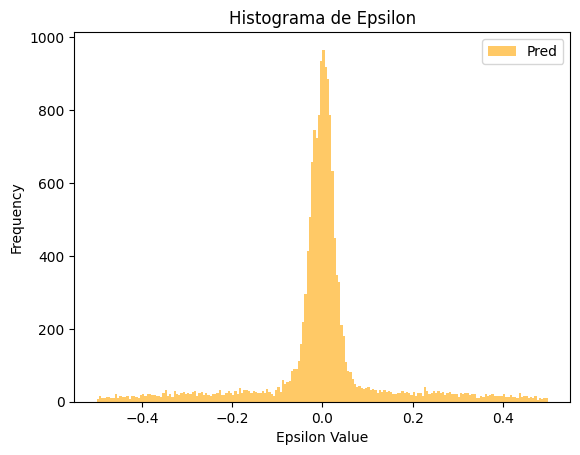

In [20]:
intensity_histogram(epsilon)

## Visualization

In [21]:
def plot_record(epsilon, kappa, show_axis=False, cmap=None):
    if show_axis:
        axis = 'on'
    else:
        axis = 'off'

    epsilon_vmin = np.min(epsilon)
    epsilon_vmax = np.max(epsilon)

    kappa_vmin = np.min(kappa)
    kappa_vmax = np.max(kappa)

    plt.figure(figsize=(12, 7))

    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    plt.subplot(1, 4, 1)
    plt.imshow(epsilon[0], vmin=epsilon_vmin, vmax=epsilon_vmax, cmap=cmap)
    plt.title('Epsilon 1')
    plt.axis(axis)

    plt.subplot(1, 4, 2)
    plt.imshow(epsilon[1], vmin=epsilon_vmin, vmax=epsilon_vmax, cmap=cmap)
    plt.title('Epsilon 2')
    plt.axis(axis)

    plt.subplot(1, 4, 3)
    plt.imshow(epsilon[2], vmin=epsilon_vmin, vmax=epsilon_vmax, cmap=cmap)
    plt.title('Delta Epsilon')
    plt.axis(axis)

    plt.subplot(1, 4, 4)
    plt.imshow(kappa, vmin=kappa_vmin, vmax=kappa_vmax, cmap=cmap)
    plt.title('Kappa')
    plt.axis(axis)

    plt.show()

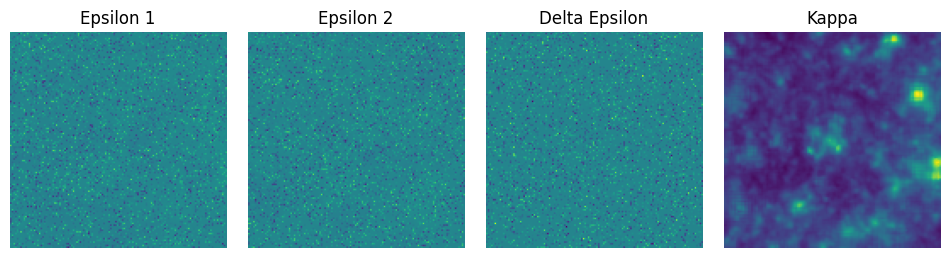

In [22]:
plot_record(epsilon_data, kappa_data, show_axis=False)

In [23]:
def plot_kappa(kappa_true, kappa_pred, show_axis=False, show_dpeaks=False, cmap=None):
    kt= kappa_true.astype(np.float32)
    kp= kappa_pred.astype(np.float32)
    if show_axis:
        axis = 'on'
        plt.figure(figsize=(7, 3))
    else:
        axis = 'off'
        plt.figure(figsize=(6, 3))

    if show_dpeaks:
        dpeaks_true = find_top_k_peaks(kt)
        dpeaks_pred = find_top_k_peaks(kp)
        dpeaks_true_x, dpeaks_true_y = dpeaks_true[:, 1], dpeaks_true[:, 0]
        dpeaks_pred_x, dpeaks_pred_y = dpeaks_pred[:, 1], dpeaks_pred[:, 0]

    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    plt.subplot(1, 2, 1)
    plt.imshow(kt, cmap=cmap)
    plt.title('Kappa True')
    if show_dpeaks:
        plt.scatter(dpeaks_true_x, dpeaks_true_y, color='red')
        for i in range(len(dpeaks_true_y)):
            plt.text(dpeaks_true_x[i], dpeaks_true_y[i], str(i + 1), fontsize=12, ha='right', va='bottom', color='red')

    plt.axis(axis)

    plt.subplot(1, 2, 2)
    plt.imshow(kp, cmap=cmap)
    plt.title('Kappa Prediction')
    if show_dpeaks:
        plt.scatter(dpeaks_pred_x, dpeaks_pred_y, color='red')
        for i in range(len(dpeaks_true_y)):
            plt.text(dpeaks_pred_x[i], dpeaks_pred_y[i], str(i + 1), fontsize=12, ha='right', va='bottom', color='red')
    plt.axis(axis)

    plt.show()

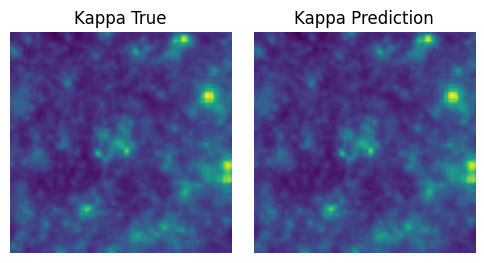

In [24]:
plot_kappa(kappa_data, kappa_data, show_dpeaks=False)

# DPeaks Testing

In [25]:
import numpy as np
from scipy.ndimage import maximum_filter, label, find_objects

def find_peaks(data, threshold=None, neighborhood_size=3):
    # Apply a maximum filter to find local maxima
    data_max = maximum_filter(data, neighborhood_size)

    # Create a boolean mask where the data is equal to the local maximum
    maxima = (data == data_max)

    if threshold is not None:
        # Apply the threshold
        maxima[data > threshold] = False

    # Label the maxima
    labeled, num_objects = label(maxima)

    # Get the coordinates of the maxima
    slices = find_objects(labeled)
    coordinates = []
    for dy, dx in slices:
        x_center = (dx.start + dx.stop - 1) // 2
        y_center = (dy.start + dy.stop - 1) // 2
        coordinates.append((x_center, y_center))

    return np.array(coordinates)

def find_n_max_peaks(data, n=10, threshold=None, neighborhood_size=3, verbose=False):
    # Find the peaks
    peaks = find_peaks(data, threshold, neighborhood_size)

    peaks2 = []

    for x, y in peaks:
        intensity = data[x, y]
        if verbose: print(f"Peak at ({x}, {y}) with intensity {intensity}")

        peaks2.append((x, y, intensity))

    # Sort the peaks by intensity in descending order
    peaks2.sort(key=lambda x: x[2], reverse=True)

    coords = [(x, y) for x, y, _ in peaks2]
    intensities = [intensity for _, _, intensity in peaks2]

    # Return the top n peaks
    return np.array(coords[:n]), np.array(intensities[:n])

# Metrics

In [26]:
y_true = torch.from_numpy(kappa_data)
y_pred = torch.from_numpy(kappa_data)

## WMAPE

In [27]:
def wmape_handcrafted(y_true : torch.Tensor, y_pred : torch.Tensor):
    W = 1 + (y_true / torch.max(y_true))

    y_true = torch.where(y_true == 0, torch.tensor(1e-7), y_true)
    randderecha = torch.abs(y_pred - y_true) / torch.abs(y_true)
    num = torch.sum(W * randderecha)

    denom = torch.sum(W)
    return (num / denom).item()

def wmape(T:torch.Tensor, P:torch.Tensor, delta = torch.tensor(1e-5)):
    T = torch.where(T == 0.0, delta, T)
    P = torch.where(P == 0.0, delta, P)
    W_fun = lambda T, max_T: 1 + (T/max_T)
    max_T = torch.max(T)
    W = W_fun(T, max_T)
    Numerator = W*(torch.abs(P-T)/torch.abs(T))
    sum_W = torch.sum(W)
    sum_Numerator = torch.sum(Numerator)
    return (sum_Numerator/sum_W).item()

wmape(y_true, y_pred), wmape_handcrafted(y_true, y_pred)

(0.0, 0.0)

## DICEE

In [28]:
def dicee_handcrafted(y_true: torch.Tensor, y_pred: torch.Tensor, alpha=0.5, beta=0.5):
    G = (y_true > torch.mean(y_true)).int()
    A = (y_pred > torch.mean(y_pred)).int()
    return (1 - torch.sum(G * A) / (torch.sum(G * A) + alpha * torch.sum((1 - G) * A) + beta * torch.sum((1 - A) * G))).item()

def DICE_binary_mask(Tensor:torch.tensor):
    Tensor_mask = Tensor - torch.mean(Tensor)
    Tensor_mask[torch.where(Tensor_mask > 0)] = 1
    Tensor_mask[torch.where(Tensor_mask <= 0)] = 0
    return Tensor_mask

def dicee(T:torch.Tensor, P:torch.Tensor, alpha:float = 0.5, beta:float = 0.5):
    if T.shape != P.shape: return None
    G = DICE_binary_mask(T)
    A = DICE_binary_mask(P)
    sum_G_A = torch.sum(G*A)
    sum_alpha = torch.sum(A*(1-G))
    sum_beta = torch.sum(G*(1-A))
    return (1-(sum_G_A/(sum_G_A + alpha*sum_alpha + beta*sum_beta))).item()

dicee(y_true, y_pred), dicee_handcrafted(y_true, y_pred)

(0.0, 0.0)

## DPeaks

In [29]:
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max

def find_top_k_peaks(im ,sigma=3, N=3):
    smoothed = gaussian_filter(im, sigma=sigma)
    coordinates = peak_local_max(smoothed,threshold_abs=None, num_peaks=N)
    while len(coordinates) < 3: coordinates = np.vstack([coordinates,np.array([0,0])])
    return coordinates

def official_dpeaks(T:np.ndarray, P:np.ndarray, num_peaks = 3):
    PEAKS_T = find_top_k_peaks(T, N=num_peaks)
    PEAKS_P = find_top_k_peaks(P, N=num_peaks)
    sum_DPEAKS = np.sum(np.abs(PEAKS_T-PEAKS_P))
    return sum_DPEAKS

def dpeaks(y_true : torch.Tensor, y_pred : torch.Tensor, num_peaks=3):
    y_true_np = y_true.cpu().numpy().astype(np.float32)
    y_pred_np = y_pred.cpu().numpy().astype(np.float32)

    dpeaks_sum = 0
    batch_size = y_true_np.shape[0]

    for i in range(batch_size):
        y_true_im = y_true_np[i].squeeze()
        y_pred_im = y_pred_np[i].squeeze()

        dpeaks_im = official_dpeaks(y_true_im, y_pred_im, num_peaks)
        dpeaks_sum += dpeaks_im

    return (dpeaks_sum / batch_size).item()

dpeaks(y_true, y_pred)

0.0

# Loss

In [30]:
class WeightedMSELoss(nn.Module):
    def __init__(self):
        super(WeightedMSELoss, self).__init__()

    def forward(self, y_pred, y_true):
        max_val = torch.max(y_true)
        weights = 1 + (torch.abs(y_true) / max_val)

        loss = weights * (y_pred - y_true) ** 2
        return torch.sum(loss)

In [31]:
class CombinedLoss(nn.Module):
    def __init__(self, WMSE_w= 0.3, dicee_w= 0.3, WMAPE_w= 0.3, dpeaks_w= 0.1):
        super(CombinedLoss, self).__init__()
        self.WMSE_loss= WeightedMSELoss()
        self.WMSE_w =  WMSE_w
        self.dicee_w= dicee_w
        self.WMAPE_w= WMAPE_w
        self.dpeaks_w= dpeaks_w

    def forward(self, y_pred, y_true):
        y_pred_detach=y_pred.detach()
        y_true_detach=y_true.detach()

        WMSE_loss = self.WMSE_loss(y_pred, y_true)
        dicee_loss = dicee(y_pred_detach, y_true_detach)
        WMAPE_loss = wmape(y_pred_detach, y_true_detach)
        dpeaks_loss = dpeaks(y_pred_detach, y_true_detach)

        # print(f"WMSE: {WMSE_loss*self.WMSE_w}")
        # print(f"dicee: {dicee_loss*self.dicee_w}")
        # print(f"WMAPE: {WMAPE_loss*self.WMAPE_w}")
        # print(f"dpeaks: {dpeaks_loss*self.dpeaks_w}")

        return (WMSE_loss*self.WMSE_w + dicee_loss*self.dicee_w + WMAPE_loss*self.WMAPE_w + dpeaks_loss*self.dpeaks_w)

# Training functions

In [32]:
def save_checkpoint(model, optimizer, epoch, history, filepath='checkpoint.pth'):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'history': history,
        'random_state': {
            'python': random.getstate(),
            'numpy': np.random.get_state(),
            'torch': torch.get_rng_state(),
            'torch_cuda': torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None,
        }
    }
    torch.save(checkpoint, filepath)
    print(f'Checkpoint saved to {filepath}\n')

In [33]:
def load_checkpoint(model, optimizer, filename='checkpoint.pth'):
    checkpoint = torch.load(filename, weights_only=False)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch']
    history = checkpoint['history']

    random.setstate(checkpoint['random_state']['python'])
    np.random.set_state(checkpoint['random_state']['numpy'])
    torch.set_rng_state(checkpoint['random_state']['torch'])
    if torch.cuda.is_available() and checkpoint['random_state']['torch_cuda'] is not None:
        torch.cuda.set_rng_state_all(checkpoint['random_state']['torch_cuda'])

    return epoch, history

In [34]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, start_epoch=None, metrics=None, scheduler=None, device='cuda'):

    history = {
        'train_losses': [],
        'val_losses': [],
        }

    if metrics is not None:
        for metric_name in metrics.keys():
            history[f'train_{metric_name}'] = []
            history[f'val_{metric_name}'] = []

    if scheduler is not None:
        history['lr'] = []

    if start_epoch is None:
        start_epoch = 1

    if start_epoch > epochs:
        raise ValueError("start_epoch must be less than or equal to epochs")

    for epoch in range(start_epoch, epochs + 1):
        model.train()

        train_p_bar = tqdm(enumerate(train_loader), total=len(train_loader))

        epoch_train_loss = 0
        epoch_val_loss = 0

        if metrics is not None:
            epoch_train_metrics = {metric_name: 0 for metric_name in metrics.keys()}
            epoch_val_metrics = {metric_name: 0 for metric_name in metrics.keys()}


        for _, (epsilon, kappa) in train_p_bar:
            epsilon, kappa = epsilon.to(device), kappa.to(device)

            optimizer.zero_grad()

            y_hat = model(epsilon)
            loss = criterion(y_hat, kappa)
            loss.backward()
            optimizer.step()

            batch_size = epsilon.size(0)

            epoch_train_loss += loss.item() * batch_size

            kappa_detached = kappa.detach().cpu()
            y_hat_detached = y_hat.detach().cpu()
            if metrics is not None:
                for metric_name, metric_fn in metrics.items():
                    metric_value = metric_fn(kappa_detached, y_hat_detached)
                    epoch_train_metrics[metric_name] += metric_value * batch_size

            train_p_bar.set_description(f"Epoch: {epoch}/{epochs}, Loss: {loss.item():.4f}")


        epoch_train_loss /= len(train_loader.dataset)
        history['train_losses'].append(epoch_train_loss)

        if metrics is not None:
            for metric_name in metrics.keys():
                epoch_train_metrics[metric_name] /= len(train_loader.dataset)
                history[f'train_{metric_name}'].append(epoch_train_metrics[metric_name])

            train_metrics_formatted = ', '.join([f"{metric_name}: {epoch_train_metrics[metric_name]:.4f}" for metric_name in metrics.keys()])
            print(f"Train Metrics: Loss: {epoch_train_loss:.4f}, {train_metrics_formatted}")

        model.eval()
        with torch.inference_mode():
            val_p_bar = tqdm(enumerate(val_loader), total=len(val_loader))
            for _, (epsilon, kappa) in val_p_bar:
                epsilon, kappa = epsilon.to(device), kappa.to(device)
                y_hat = model(epsilon)
                loss = criterion(y_hat, kappa)

                batch_size = epsilon.size(0)

                epoch_val_loss += loss.item() * batch_size

                kappa_detached = kappa.detach()
                y_hat_detached = y_hat.detach()
                if metrics is not None:
                    for metric_name, metric_fn in metrics.items():
                        metric_value = metric_fn(kappa_detached, y_hat_detached)
                        epoch_val_metrics[metric_name] += metric_value * batch_size

                val_p_bar.set_description(f"Epoch: {epoch}/{epochs}, Loss: {loss.item():.4f}")

        epoch_val_loss /= len(val_loader.dataset)
        history['val_losses'].append(epoch_val_loss)

        if scheduler is not None:
            scheduler.step(epoch_val_loss)
            history["lr"].append(scheduler.get_last_lr())


        if metrics is not None:
            for metric_name in metrics.keys():
                epoch_val_metrics[metric_name] /= len(val_loader.dataset)
                history[f'val_{metric_name}'].append(epoch_val_metrics[metric_name])

            val_metrics_formatted = ', '.join([f"{metric_name}: {epoch_val_metrics[metric_name]:.4f}" for metric_name in metrics.keys()])
            print(f"Val Metrics: Loss: {epoch_val_loss:.4f}, {val_metrics_formatted}, Actual lr: {scheduler.get_last_lr() if scheduler is not None else None}")


        if epoch % CHECKPOINT_STEP == 0:
            save_checkpoint(model, optimizer, epoch, history, os.path.join(MODELS_PATH, f'{MODEL_NAME}_model_{epoch}E.pth'))
        else:
            print('\n')
    return history

In [35]:
def evaluate(model: nn.Module,
             test_loader: torch.utils.data.DataLoader,
             criterion: torch.nn.Module,
             epoch: int,
             epochs: int,
             metrics: dict,
             device: torch.device):

    metrics = {metric_name: 0 for metric_name in metrics.keys()}
    total_loss = 0

    model.eval()
    with torch.inference_mode():
        p_bar = tqdm(enumerate(test_loader), total=len(test_loader))
        for _, (epsilon, kappa) in p_bar:
            epsilon, kappa = epsilon.to(device), kappa.to(device)
            y_hat = model(epsilon)
            loss = criterion(y_hat, kappa)

            batch_size = epsilon.size(0)

            total_loss += loss.item() * batch_size

            kappa_detached = kappa.detach()
            y_hat_detached = y_hat.detach()

            for metric_name, metric_fn in metrics.items():
                metric_value = metric_fn(kappa_detached, y_hat_detached)
                metrics[metric_name] += metric_value * batch_size

            p_bar.set_description(f"Epoch: {epoch}/{epochs}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(test_loader.dataset)
    metrics_formatted = ', '.join([f"{metric_name}: {metrics[metric_name]:.4f}" for metric_name in metrics.keys()])
    print(f"Evaluation Metrics: Loss: {avg_loss:.4f}, {metrics_formatted}")

    return avg_loss, metrics

# Dataset Exploring

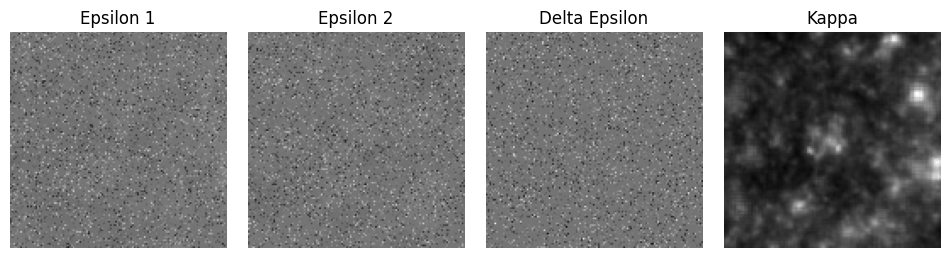

In [36]:
PATH = 'small_dataset'

epsilon = np.load(os.path.join(PATH, 'EPSILON', '00001_00001.npy'))
kappa = np.load(os.path.join(PATH, 'KAPPA', '00001_00001.npy'))

plot_record(epsilon, kappa, show_axis=False, cmap='gray')

In [37]:
kappa.shape

(128, 128)

[[ 38 114]
 [  5 101]
 [ 76 127]]


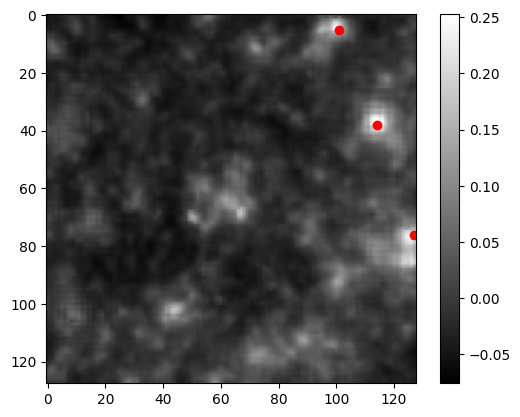

In [38]:
kappa = kappa.astype(np.float32)

coords, _ = find_n_max_peaks(kappa, n=3)
print(coords)

plt.imshow(kappa, cmap='gray')
plt.colorbar()
plt.scatter(coords[:, 1], coords[:, 0], color='red')
plt.show()

In [39]:
kappa.shape

(128, 128)

In [40]:
def crop_image(epsilon, kappa, center_coord, size=5):
    # Get the height and width of the image
    height, width = kappa.shape

    center_y, center_x  = center_coord

    half_crop_size = size//2
    top_left_x = max(0, center_x - half_crop_size)
    top_left_y = max(0, center_y - half_crop_size)
    bottom_right_x = min(width, center_x + half_crop_size + 1)
    bottom_right_y = min(height, center_y + half_crop_size + 1)

    cropped_kappa = kappa[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
    cropped_epsilon = epsilon[:, top_left_y:bottom_right_y, top_left_x:bottom_right_x]

    return cropped_epsilon, cropped_kappa

(3, 51, 39) (51, 39)


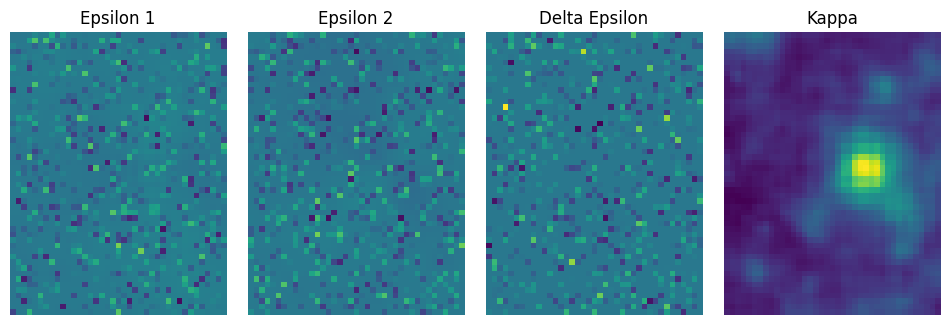

In [41]:
epsilon_cropped, kappa_cropped = crop_image(epsilon, kappa, coords[0], size=50)
print(epsilon_cropped.shape, kappa_cropped.shape)
plot_record(epsilon_cropped, kappa_cropped, show_axis=False)

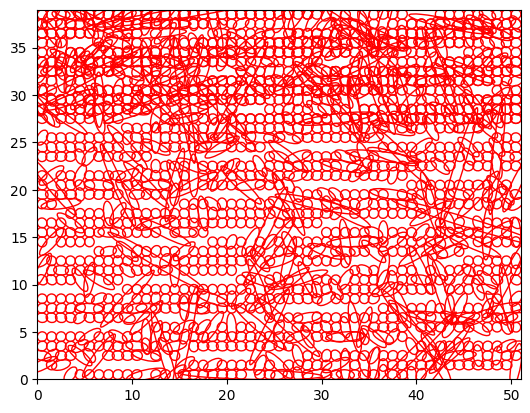

In [42]:
import matplotlib.patches as patches


epsilon_1, epsilon_2 = epsilon_cropped[0], epsilon_cropped[1]
step = 1

x, y = step/2, step/2

fig, ax = plt.subplots()
ax.set_xlim(0, epsilon_1.shape[0] * step)
ax.set_ylim(0, epsilon_1.shape[1] * step)

def convert_coords(x, y, height):
    return x, height - y

height = ax.get_ylim()[1]

for i in range(epsilon_1.shape[0]):
    for j in range(epsilon_1.shape[1]):
        epsilon_1_val = epsilon_1[i, j]
        epsilon_2_val = epsilon_2[i, j]

        phi = 0.5 * np.arctan2(epsilon_2_val, epsilon_1_val) * 180 / np.pi
        e = np.sqrt(epsilon_1_val**2 + epsilon_2_val**2)
        a = (1 + e) / (1 - e)
        b = 1 #(1 - e) / (1 + e)
        # angle = 0

        # Create an ellipse
        #ellipse = patches.Ellipse(convert_coords(x, y, height), width=2*epsilon_1_val, height=2*epsilon_2_val, angle=angle, edgecolor='r', facecolor='none')
        ellipse = patches.Ellipse(convert_coords(x, y, height), width=a, height=b, angle=phi, edgecolor='r', facecolor='none')
        #ellipse = patches.Ellipse((x, y), width=1, height=1, angle=angle, edgecolor='r', facecolor='none')

        ax.add_patch(ellipse)
        x += step
        x = x % (epsilon_1.shape[0] * step)
    y += step
    y = y % (epsilon_1.shape[1] * step)

ax.set_aspect('equal')
plt.show()

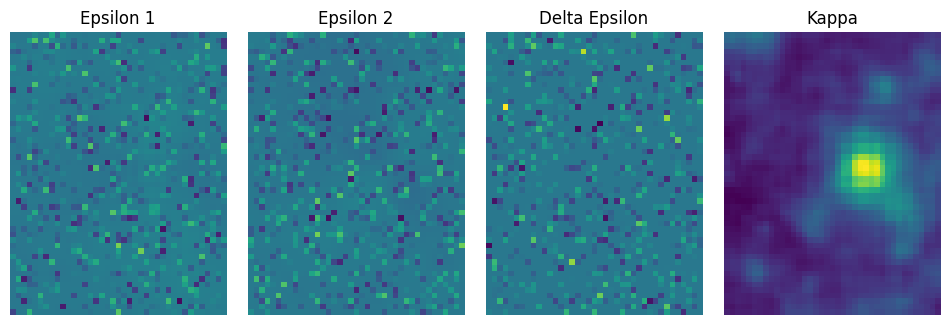

In [43]:
plot_record(epsilon_cropped, kappa_cropped, show_axis=False)

# Model

## Blocks

In [44]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class DoubleConv(nn.Module):
    def __init__(self, in_channels=3, out_channels=64, mid_channels=None, kernel_size=3, activation=F.relu):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=mid_channels, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv2d(in_channels=mid_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1)
        if activation == F.tanh:
            nn.init.xavier_uniform_(self.conv1.weight)
            nn.init.xavier_uniform_(self.conv2.weight)
        self.conv1x1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1)

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.activation = activation


    def forward(self, x):
        out = self.activation(self.bn1(self.conv1(x)))

        x = self.conv1x1(x)

        out = self.activation(self.bn2(self.conv2(out)) + x)
        return out


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=None, activation=F.relu):
        super(Down, self).__init__()

        if dropout is not None:
            self.p = dropout
            self.dropout = nn.Dropout(p=self.p)
        else:
            self.dropout = nn.Identity()

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.double_conv = DoubleConv(in_channels, out_channels, kernel_size=kernel_size, activation=activation)

    def forward(self, x):
        x = self.dropout(x)
        x = self.maxpool(x)
        x = self.double_conv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3 ,activation=F.relu, bilinear=False):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels=in_channels, out_channels=out_channels, mid_channels=in_channels // 2, kernel_size=kernel_size,activation=activation)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
        self.attention= AttentionBlock(F_g=in_channels // 2, F_l=in_channels // 2, F_int=in_channels // 4)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x2= self.attention(g=x1, x=x2)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)



class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

## Model

In [45]:
class AttentionResUnet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, kernel_size=3, dropout=None, activation=F.relu, bilinear=False, features=[64, 128, 256, 512, 1024]):
        super(AttentionResUnet, self).__init__()

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.bilinear = bilinear

        self.encoder.append(DoubleConv(in_channels=in_channels, out_channels=features[0], kernel_size=kernel_size, activation=activation))
        for i in range(1, len(features)):
            self.encoder.append(Down(in_channels=features[i-1], out_channels=features[i], kernel_size=kernel_size, dropout=dropout, activation=activation))

        for i in range(len(features) - 1, 0, -1):
            self.decoder.append(Up(in_channels=features[i], out_channels=features[i-1], kernel_size=kernel_size, activation=F.relu, bilinear=self.bilinear))

        self.outconv = OutConv(in_channels=features[0], out_channels=out_channels)

    def forward(self, x):
        skips = []
        for down in self.encoder:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])

        for up, skip in zip(self.decoder, skips):
            x = up(x, skip)

        return self.outconv(x)


# Training

In [46]:
INITIAL_LR = 0.00001
TARGET_LR = 0.0001
WARMUP_EPOCHS = 10
EPOCHS = 50

In [47]:
def lr_lambda(epoch):
    if epoch < WARMUP_EPOCHS:
        return (TARGET_LR / INITIAL_LR) * (epoch / WARMUP_EPOCHS)
    return 10

In [48]:
MODEL_NAME = 'Attention_resUnetW_CombinedLoss'

In [49]:
print(f'Using device: {DEVICE}')

model = AttentionResUnet(in_channels=3, features=[32, 64, 128, 256, 512]).to(DEVICE)
#model = torch.compile(model)

# criterion = WeightedMSELoss()
criterion = CombinedLoss(WMAPE_w= 10, dicee_w= 300, dpeaks_w= 1)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
EPOCHS = 100

scheduler = lr_scheduler.ReduceLROnPlateau(
   optimizer,
   mode='min',
   factor=0.1,
   patience=5,
   threshold=0.01,
   min_lr=1e-6
)

#scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)
# scheduler = None
metrics = {
    'wmape': wmape,
    'dicee': dicee,
    'dpeaks': dpeaks
}

Using device: cuda


In [50]:
RESUME_TRAINING = False
CHECKPOINT_FILEPATH = os.path.join(MODELS_PATH, 'basic_CNN_model_1E.pth') # the model should be in the models folder

if RESUME_TRAINING:
    last_epoch, history = load_checkpoint(model, optimizer, CHECKPOINT_FILEPATH)

# TODO: integrate history

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
history = train(model, train_loader, val_loader, criterion, optimizer, scheduler=scheduler, epochs=EPOCHS, metrics=metrics, device=DEVICE)

Epoch: 1/100, Loss: 622.0191: 100%|██████████| 175/175 [01:18<00:00,  2.22it/s]

Train Metrics: Loss: 2504.2676, wmape: 8.0261, dicee: 0.6333, dpeaks: 212.1391



Epoch: 1/100, Loss: 768.2516: 100%|██████████| 47/47 [00:12<00:00,  3.73it/s]

Val Metrics: Loss: 1100.2971, wmape: 3.8371, dicee: 0.5816, dpeaks: 186.0377, Actual lr: [0.01]





Epoch: 2/100, Loss: 429.8500: 100%|██████████| 175/175 [01:16<00:00,  2.28it/s]

Train Metrics: Loss: 832.3929, wmape: 3.4379, dicee: 0.5206, dpeaks: 177.6858



Epoch: 2/100, Loss: 520.9470: 100%|██████████| 47/47 [00:12<00:00,  3.89it/s]

Val Metrics: Loss: 581.3609, wmape: 4.4416, dicee: 0.4038, dpeaks: 166.5562, Actual lr: [0.01]





Epoch: 3/100, Loss: 256.4346: 100%|██████████| 175/175 [01:16<00:00,  2.28it/s]

Train Metrics: Loss: 440.7005, wmape: 4.5863, dicee: 0.3233, dpeaks: 139.2603



Epoch: 3/100, Loss: 342.4757: 100%|██████████| 47/47 [00:12<00:00,  3.72it/s]

Val Metrics: Loss: 416.6561, wmape: 5.4395, dicee: 0.2691, dpeaks: 122.3556, Actual lr: [0.01]





Epoch: 4/100, Loss: 346.3247: 100%|██████████| 175/175 [01:15<00:00,  2.32it/s]

Train Metrics: Loss: 314.7564, wmape: 4.3636, dicee: 0.2336, dpeaks: 107.6106



Epoch: 4/100, Loss: 232.6746: 100%|██████████| 47/47 [00:12<00:00,  3.69it/s]

Val Metrics: Loss: 315.4929, wmape: 4.4189, dicee: 0.2191, dpeaks: 109.5576, Actual lr: [0.01]





Epoch: 5/100, Loss: 119.5151: 100%|██████████| 175/175 [01:16<00:00,  2.30it/s]

Train Metrics: Loss: 242.7291, wmape: 3.8588, dicee: 0.1867, dpeaks: 87.2165



Epoch: 5/100, Loss: 262.1147: 100%|██████████| 47/47 [00:12<00:00,  3.87it/s]


Val Metrics: Loss: 398.6613, wmape: 8.3317, dicee: 0.1775, dpeaks: 84.0539, Actual lr: [0.01]
Checkpoint saved to models/Attention_resUnetW_CombinedLoss_model_5E.pth



Epoch: 6/100, Loss: 91.3982: 100%|██████████| 175/175 [01:17<00:00,  2.24it/s]

Train Metrics: Loss: 204.8971, wmape: 3.5459, dicee: 0.1588, dpeaks: 73.1749



Epoch: 6/100, Loss: 195.4475: 100%|██████████| 47/47 [00:12<00:00,  3.65it/s]

Val Metrics: Loss: 229.6209, wmape: 4.1339, dicee: 0.1711, dpeaks: 77.3825, Actual lr: [0.01]





Epoch: 7/100, Loss: 76.1476: 100%|██████████| 175/175 [01:15<00:00,  2.32it/s]

Train Metrics: Loss: 174.6469, wmape: 3.1688, dicee: 0.1398, dpeaks: 64.8607



Epoch: 7/100, Loss: 184.5718: 100%|██████████| 47/47 [00:12<00:00,  3.72it/s]

Val Metrics: Loss: 202.0206, wmape: 3.3273, dicee: 0.1477, dpeaks: 75.7077, Actual lr: [0.01]





Epoch: 8/100, Loss: 92.4448: 100%|██████████| 175/175 [01:15<00:00,  2.32it/s]

Train Metrics: Loss: 161.0003, wmape: 3.0377, dicee: 0.1281, dpeaks: 60.8470



Epoch: 8/100, Loss: 177.8374: 100%|██████████| 47/47 [00:12<00:00,  3.79it/s]

Val Metrics: Loss: 199.7240, wmape: 3.3626, dicee: 0.1501, dpeaks: 79.3178, Actual lr: [0.01]





Epoch: 9/100, Loss: 58.6293: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]

Train Metrics: Loss: 151.4935, wmape: 2.8306, dicee: 0.1196, dpeaks: 58.1535



Epoch: 9/100, Loss: 132.4374: 100%|██████████| 47/47 [00:13<00:00,  3.57it/s]

Val Metrics: Loss: 162.3053, wmape: 2.6271, dicee: 0.1280, dpeaks: 62.1582, Actual lr: [0.01]





Epoch: 10/100, Loss: 208.3951: 100%|██████████| 175/175 [01:17<00:00,  2.27it/s]

Train Metrics: Loss: 144.2790, wmape: 2.6739, dicee: 0.1116, dpeaks: 56.6470



Epoch: 10/100, Loss: 139.9812: 100%|██████████| 47/47 [00:12<00:00,  3.67it/s]


Val Metrics: Loss: 184.0026, wmape: 4.6480, dicee: 0.1259, dpeaks: 61.0141, Actual lr: [0.01]
Checkpoint saved to models/Attention_resUnetW_CombinedLoss_model_10E.pth



Epoch: 11/100, Loss: 117.6304: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]

Train Metrics: Loss: 134.9114, wmape: 2.6320, dicee: 0.1062, dpeaks: 51.7276



Epoch: 11/100, Loss: 173.6543: 100%|██████████| 47/47 [00:12<00:00,  3.65it/s]

Val Metrics: Loss: 226.7282, wmape: 5.3616, dicee: 0.1201, dpeaks: 58.8505, Actual lr: [0.01]





Epoch: 12/100, Loss: 50.3842: 100%|██████████| 175/175 [01:17<00:00,  2.27it/s]

Train Metrics: Loss: 127.8905, wmape: 2.5080, dicee: 0.1010, dpeaks: 49.3194



Epoch: 12/100, Loss: 297.2596: 100%|██████████| 47/47 [00:12<00:00,  3.70it/s]

Val Metrics: Loss: 466.2873, wmape: 12.6019, dicee: 0.1164, dpeaks: 60.7273, Actual lr: [0.01]





Epoch: 13/100, Loss: 135.2008: 100%|██████████| 175/175 [01:17<00:00,  2.26it/s]

Train Metrics: Loss: 128.4929, wmape: 2.5526, dicee: 0.0977, dpeaks: 48.8553



Epoch: 13/100, Loss: 141.6335: 100%|██████████| 47/47 [00:12<00:00,  3.63it/s]

Val Metrics: Loss: 180.4940, wmape: 4.6153, dicee: 0.1124, dpeaks: 55.5657, Actual lr: [0.01]





Epoch: 14/100, Loss: 193.7536: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]

Train Metrics: Loss: 125.8164, wmape: 2.4789, dicee: 0.0945, dpeaks: 49.1099



Epoch: 14/100, Loss: 100.7307: 100%|██████████| 47/47 [00:13<00:00,  3.59it/s]

Val Metrics: Loss: 160.8602, wmape: 3.7672, dicee: 0.1169, dpeaks: 59.2323, Actual lr: [0.01]





Epoch: 15/100, Loss: 53.1536: 100%|██████████| 175/175 [01:15<00:00,  2.32it/s]

Train Metrics: Loss: 118.7795, wmape: 2.2986, dicee: 0.0894, dpeaks: 47.1124



Epoch: 15/100, Loss: 130.7679: 100%|██████████| 47/47 [00:13<00:00,  3.59it/s]


Val Metrics: Loss: 174.5923, wmape: 2.9959, dicee: 0.1303, dpeaks: 78.1266, Actual lr: [0.001]
Checkpoint saved to models/Attention_resUnetW_CombinedLoss_model_15E.pth



Epoch: 16/100, Loss: 44.2276: 100%|██████████| 175/175 [01:15<00:00,  2.32it/s]

Train Metrics: Loss: 94.4752, wmape: 1.8534, dicee: 0.0754, dpeaks: 40.0352



Epoch: 16/100, Loss: 127.4600: 100%|██████████| 47/47 [00:12<00:00,  3.65it/s]

Val Metrics: Loss: 103.9098, wmape: 2.1016, dicee: 0.0909, dpeaks: 41.1468, Actual lr: [0.001]





Epoch: 17/100, Loss: 104.1774: 100%|██████████| 175/175 [01:15<00:00,  2.30it/s]

Train Metrics: Loss: 89.9729, wmape: 1.7910, dicee: 0.0717, dpeaks: 38.0151



Epoch: 17/100, Loss: 107.0702: 100%|██████████| 47/47 [00:13<00:00,  3.58it/s]

Val Metrics: Loss: 107.1765, wmape: 2.0677, dicee: 0.0917, dpeaks: 43.3865, Actual lr: [0.001]





Epoch: 18/100, Loss: 49.8267: 100%|██████████| 175/175 [01:17<00:00,  2.27it/s]

Train Metrics: Loss: 89.2214, wmape: 1.7289, dicee: 0.0701, dpeaks: 37.2478



Epoch: 18/100, Loss: 118.1022: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s]

Val Metrics: Loss: 102.7720, wmape: 2.0204, dicee: 0.0899, dpeaks: 40.7387, Actual lr: [0.001]





Epoch: 19/100, Loss: 55.9210: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]

Train Metrics: Loss: 87.4987, wmape: 1.7242, dicee: 0.0690, dpeaks: 36.5449



Epoch: 19/100, Loss: 124.2146: 100%|██████████| 47/47 [00:11<00:00,  3.95it/s]

Val Metrics: Loss: 117.4888, wmape: 2.4269, dicee: 0.0904, dpeaks: 40.8027, Actual lr: [0.001]





Epoch: 20/100, Loss: 46.0939: 100%|██████████| 175/175 [01:17<00:00,  2.26it/s]

Train Metrics: Loss: 88.0369, wmape: 1.7142, dicee: 0.0680, dpeaks: 37.1605



Epoch: 20/100, Loss: 90.1893: 100%|██████████| 47/47 [00:12<00:00,  3.69it/s]


Val Metrics: Loss: 102.7524, wmape: 1.9535, dicee: 0.0892, dpeaks: 40.0943, Actual lr: [0.001]
Checkpoint saved to models/Attention_resUnetW_CombinedLoss_model_20E.pth



Epoch: 21/100, Loss: 38.9894: 100%|██████████| 175/175 [01:16<00:00,  2.28it/s]

Train Metrics: Loss: 86.2578, wmape: 1.7382, dicee: 0.0671, dpeaks: 35.8702



Epoch: 21/100, Loss: 106.5524: 100%|██████████| 47/47 [00:13<00:00,  3.60it/s]

Val Metrics: Loss: 106.3107, wmape: 1.9752, dicee: 0.0890, dpeaks: 40.0370, Actual lr: [0.001]





Epoch: 22/100, Loss: 95.1651: 100%|██████████| 175/175 [01:17<00:00,  2.26it/s]

Train Metrics: Loss: 84.6066, wmape: 1.7023, dicee: 0.0662, dpeaks: 35.3467



Epoch: 22/100, Loss: 105.1514: 100%|██████████| 47/47 [00:12<00:00,  3.78it/s]

Val Metrics: Loss: 121.9755, wmape: 2.4263, dicee: 0.0884, dpeaks: 39.3475, Actual lr: [0.001]





Epoch: 23/100, Loss: 46.1414: 100%|██████████| 175/175 [01:16<00:00,  2.28it/s]

Train Metrics: Loss: 84.0435, wmape: 1.7067, dicee: 0.0655, dpeaks: 34.3937



Epoch: 23/100, Loss: 99.2910: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s]

Val Metrics: Loss: 102.3183, wmape: 2.2544, dicee: 0.0890, dpeaks: 39.4525, Actual lr: [0.001]





Epoch: 24/100, Loss: 53.5660: 100%|██████████| 175/175 [01:16<00:00,  2.27it/s]

Train Metrics: Loss: 84.3475, wmape: 1.7152, dicee: 0.0646, dpeaks: 33.9908



Epoch: 24/100, Loss: 100.5782: 100%|██████████| 47/47 [00:13<00:00,  3.61it/s]

Val Metrics: Loss: 101.3290, wmape: 2.0610, dicee: 0.0884, dpeaks: 38.6505, Actual lr: [0.001]





Epoch: 25/100, Loss: 132.0875: 100%|██████████| 175/175 [01:17<00:00,  2.26it/s]

Train Metrics: Loss: 82.2122, wmape: 1.6184, dicee: 0.0637, dpeaks: 33.9327



Epoch: 25/100, Loss: 90.4781: 100%|██████████| 47/47 [00:12<00:00,  3.77it/s]


Val Metrics: Loss: 98.9435, wmape: 1.9381, dicee: 0.0872, dpeaks: 37.4350, Actual lr: [0.001]
Checkpoint saved to models/Attention_resUnetW_CombinedLoss_model_25E.pth



Epoch: 26/100, Loss: 85.3732: 100%|██████████| 175/175 [01:16<00:00,  2.30it/s]

Train Metrics: Loss: 80.0064, wmape: 1.6421, dicee: 0.0631, dpeaks: 33.2873



Epoch: 26/100, Loss: 127.2466: 100%|██████████| 47/47 [00:13<00:00,  3.59it/s]

Val Metrics: Loss: 103.4044, wmape: 1.9656, dicee: 0.0895, dpeaks: 40.2047, Actual lr: [0.001]





Epoch: 27/100, Loss: 71.9489: 100%|██████████| 175/175 [01:15<00:00,  2.33it/s]

Train Metrics: Loss: 77.6627, wmape: 1.6229, dicee: 0.0623, dpeaks: 31.9099



Epoch: 27/100, Loss: 116.8209: 100%|██████████| 47/47 [00:12<00:00,  3.64it/s]

Val Metrics: Loss: 107.6359, wmape: 1.8220, dicee: 0.0871, dpeaks: 40.3811, Actual lr: [0.001]





Epoch: 28/100, Loss: 32.6010: 100%|██████████| 175/175 [01:15<00:00,  2.31it/s]

Train Metrics: Loss: 78.0165, wmape: 1.6225, dicee: 0.0617, dpeaks: 31.5510



Epoch: 28/100, Loss: 90.4942: 100%|██████████| 47/47 [00:12<00:00,  3.75it/s]

Val Metrics: Loss: 124.7802, wmape: 2.0772, dicee: 0.0870, dpeaks: 39.7710, Actual lr: [0.001]





Epoch: 29/100, Loss: 31.2598: 100%|██████████| 175/175 [01:17<00:00,  2.27it/s]

Train Metrics: Loss: 79.3045, wmape: 1.5644, dicee: 0.0611, dpeaks: 31.5729



Epoch: 29/100, Loss: 88.9561: 100%|██████████| 47/47 [00:13<00:00,  3.61it/s]

Val Metrics: Loss: 96.7583, wmape: 1.9372, dicee: 0.0873, dpeaks: 37.5906, Actual lr: [0.001]





Epoch: 30/100, Loss: 105.7325: 100%|██████████| 175/175 [01:17<00:00,  2.27it/s]

Train Metrics: Loss: 76.9278, wmape: 1.6078, dicee: 0.0605, dpeaks: 30.3618



Epoch: 30/100, Loss: 106.1237: 100%|██████████| 47/47 [00:12<00:00,  3.63it/s]


Val Metrics: Loss: 133.8106, wmape: 3.1526, dicee: 0.0860, dpeaks: 37.6539, Actual lr: [0.001]
Checkpoint saved to models/Attention_resUnetW_CombinedLoss_model_30E.pth



Epoch: 31/100, Loss: 156.3757: 100%|██████████| 175/175 [01:17<00:00,  2.26it/s]

Train Metrics: Loss: 76.4373, wmape: 1.6057, dicee: 0.0605, dpeaks: 30.5975



Epoch: 31/100, Loss: 110.4702: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s]

Val Metrics: Loss: 114.5330, wmape: 2.2325, dicee: 0.0873, dpeaks: 39.1609, Actual lr: [0.001]





Epoch: 32/100, Loss: 129.5851: 100%|██████████| 175/175 [01:16<00:00,  2.29it/s]

Train Metrics: Loss: 74.1296, wmape: 1.5923, dicee: 0.0598, dpeaks: 29.8910



Epoch: 32/100, Loss: 88.5921: 100%|██████████| 47/47 [00:13<00:00,  3.53it/s]

Val Metrics: Loss: 102.5029, wmape: 1.8609, dicee: 0.0872, dpeaks: 40.4976, Actual lr: [0.001]





Epoch: 33/100, Loss: 56.8213: 100%|██████████| 175/175 [01:17<00:00,  2.24it/s]

Train Metrics: Loss: 72.9455, wmape: 1.5495, dicee: 0.0591, dpeaks: 29.3025



Epoch: 33/100, Loss: 75.9962: 100%|██████████| 47/47 [00:13<00:00,  3.61it/s]

Val Metrics: Loss: 94.0322, wmape: 1.9423, dicee: 0.0858, dpeaks: 36.9273, Actual lr: [0.001]





Epoch: 34/100, Loss: 133.1499: 100%|██████████| 175/175 [01:16<00:00,  2.27it/s]

Train Metrics: Loss: 71.5209, wmape: 1.5408, dicee: 0.0588, dpeaks: 29.3752



Epoch: 34/100, Loss: 100.5849: 100%|██████████| 47/47 [00:12<00:00,  3.75it/s]

Val Metrics: Loss: 102.2880, wmape: 1.9838, dicee: 0.0862, dpeaks: 39.0236, Actual lr: [0.001]





Epoch: 35/100, Loss: 37.4565: 100%|██████████| 175/175 [01:17<00:00,  2.26it/s]

Train Metrics: Loss: 73.0642, wmape: 1.5877, dicee: 0.0590, dpeaks: 29.5377



Epoch: 35/100, Loss: 104.7560: 100%|██████████| 47/47 [00:12<00:00,  3.75it/s]


Val Metrics: Loss: 100.6939, wmape: 1.9447, dicee: 0.0860, dpeaks: 38.3003, Actual lr: [0.001]
Checkpoint saved to models/Attention_resUnetW_CombinedLoss_model_35E.pth



Epoch: 36/100, Loss: 44.8177: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]

Train Metrics: Loss: 70.6391, wmape: 1.5110, dicee: 0.0581, dpeaks: 28.4381



Epoch: 36/100, Loss: 279.9691: 100%|██████████| 47/47 [00:12<00:00,  3.75it/s]

Val Metrics: Loss: 103.5658, wmape: 2.0505, dicee: 0.0863, dpeaks: 36.2997, Actual lr: [0.001]





Epoch: 37/100, Loss: 41.4834: 100%|██████████| 175/175 [01:16<00:00,  2.28it/s]

Train Metrics: Loss: 72.8852, wmape: 1.5277, dicee: 0.0583, dpeaks: 29.8797



Epoch: 37/100, Loss: 102.5764: 100%|██████████| 47/47 [00:12<00:00,  3.70it/s]

Val Metrics: Loss: 107.9914, wmape: 2.1781, dicee: 0.0842, dpeaks: 36.4848, Actual lr: [0.001]





Epoch: 38/100, Loss: 105.2104: 100%|██████████| 175/175 [01:16<00:00,  2.29it/s]

Train Metrics: Loss: 70.9477, wmape: 1.5249, dicee: 0.0581, dpeaks: 27.4045



Epoch: 38/100, Loss: 94.7451: 100%|██████████| 47/47 [00:12<00:00,  3.89it/s]

Val Metrics: Loss: 102.8204, wmape: 1.8801, dicee: 0.0877, dpeaks: 39.8673, Actual lr: [0.001]





Epoch: 39/100, Loss: 36.9430: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]

Train Metrics: Loss: 72.5527, wmape: 1.5401, dicee: 0.0578, dpeaks: 27.7955



Epoch: 39/100, Loss: 116.1981: 100%|██████████| 47/47 [00:13<00:00,  3.53it/s]

Val Metrics: Loss: 106.1872, wmape: 2.0652, dicee: 0.0849, dpeaks: 39.6094, Actual lr: [0.0001]





Epoch: 40/100, Loss: 32.1099: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]

Train Metrics: Loss: 65.4340, wmape: 1.4411, dicee: 0.0548, dpeaks: 25.2253



Epoch: 40/100, Loss: 98.7368: 100%|██████████| 47/47 [00:12<00:00,  3.67it/s]


Val Metrics: Loss: 93.3806, wmape: 1.7851, dicee: 0.0814, dpeaks: 34.3239, Actual lr: [0.0001]
Checkpoint saved to models/Attention_resUnetW_CombinedLoss_model_40E.pth



Epoch: 41/100, Loss: 52.2941: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]

Train Metrics: Loss: 63.3426, wmape: 1.4099, dicee: 0.0540, dpeaks: 24.4171



Epoch: 41/100, Loss: 85.0003: 100%|██████████| 47/47 [00:13<00:00,  3.56it/s]

Val Metrics: Loss: 90.3924, wmape: 1.7913, dicee: 0.0816, dpeaks: 33.7912, Actual lr: [0.0001]





Epoch: 42/100, Loss: 34.1585: 100%|██████████| 175/175 [01:16<00:00,  2.28it/s]

Train Metrics: Loss: 63.4705, wmape: 1.4135, dicee: 0.0536, dpeaks: 23.3244



Epoch: 42/100, Loss: 168.1727: 100%|██████████| 47/47 [00:12<00:00,  3.75it/s]

Val Metrics: Loss: 93.6053, wmape: 1.8346, dicee: 0.0815, dpeaks: 34.0613, Actual lr: [0.0001]





Epoch: 43/100, Loss: 134.9213: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]

Train Metrics: Loss: 63.3627, wmape: 1.4024, dicee: 0.0534, dpeaks: 23.6583



Epoch: 43/100, Loss: 84.2941: 100%|██████████| 47/47 [00:12<00:00,  3.71it/s]


Val Metrics: Loss: 87.4620, wmape: 1.7438, dicee: 0.0815, dpeaks: 32.8795, Actual lr: [0.0001]




Epoch: 44/100, Loss: 29.9873: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]

Train Metrics: Loss: 63.1582, wmape: 1.4061, dicee: 0.0532, dpeaks: 24.0835



Epoch: 44/100, Loss: 84.9174: 100%|██████████| 47/47 [00:13<00:00,  3.58it/s]

Val Metrics: Loss: 90.7703, wmape: 1.8194, dicee: 0.0813, dpeaks: 34.6620, Actual lr: [0.0001]





Epoch: 45/100, Loss: 44.2375: 100%|██████████| 175/175 [01:17<00:00,  2.27it/s]

Train Metrics: Loss: 63.1611, wmape: 1.3993, dicee: 0.0529, dpeaks: 23.8684



Epoch: 45/100, Loss: 76.7494: 100%|██████████| 47/47 [00:12<00:00,  3.66it/s]


Val Metrics: Loss: 90.1733, wmape: 1.8622, dicee: 0.0815, dpeaks: 34.1731, Actual lr: [0.0001]
Checkpoint saved to models/Attention_resUnetW_CombinedLoss_model_45E.pth



Epoch: 46/100, Loss: 44.7669: 100%|██████████| 175/175 [01:17<00:00,  2.27it/s]

Train Metrics: Loss: 60.7566, wmape: 1.4032, dicee: 0.0527, dpeaks: 22.8451



Epoch: 46/100, Loss: 88.0942: 100%|██████████| 47/47 [00:13<00:00,  3.60it/s]

Val Metrics: Loss: 89.4029, wmape: 1.8331, dicee: 0.0812, dpeaks: 32.9845, Actual lr: [0.0001]





Epoch: 47/100, Loss: 42.4515: 100%|██████████| 175/175 [01:14<00:00,  2.33it/s]

Train Metrics: Loss: 61.9847, wmape: 1.4040, dicee: 0.0527, dpeaks: 23.7666



Epoch: 47/100, Loss: 100.5448: 100%|██████████| 47/47 [00:13<00:00,  3.60it/s]

Val Metrics: Loss: 91.6678, wmape: 1.8052, dicee: 0.0811, dpeaks: 33.6586, Actual lr: [0.0001]





Epoch: 48/100, Loss: 85.5238: 100%|██████████| 175/175 [01:14<00:00,  2.34it/s]

Train Metrics: Loss: 62.5169, wmape: 1.3867, dicee: 0.0525, dpeaks: 23.5540



Epoch: 48/100, Loss: 90.5248: 100%|██████████| 47/47 [00:13<00:00,  3.53it/s]

Val Metrics: Loss: 95.4571, wmape: 1.8412, dicee: 0.0813, dpeaks: 33.7145, Actual lr: [0.0001]





Epoch: 49/100, Loss: 42.9160: 100%|██████████| 175/175 [01:15<00:00,  2.30it/s]

Train Metrics: Loss: 61.5757, wmape: 1.3784, dicee: 0.0524, dpeaks: 23.6472



Epoch: 49/100, Loss: 87.7158: 100%|██████████| 47/47 [00:11<00:00,  4.00it/s]

Val Metrics: Loss: 93.7544, wmape: 1.7649, dicee: 0.0813, dpeaks: 34.6781, Actual lr: [1e-05]





Epoch: 50/100, Loss: 157.7477: 100%|██████████| 175/175 [01:17<00:00,  2.27it/s]

Train Metrics: Loss: 62.1459, wmape: 1.3741, dicee: 0.0520, dpeaks: 23.4560



Epoch: 50/100, Loss: 144.9774: 100%|██████████| 47/47 [00:13<00:00,  3.60it/s]


Val Metrics: Loss: 91.0301, wmape: 1.7694, dicee: 0.0812, dpeaks: 33.9724, Actual lr: [1e-05]
Checkpoint saved to models/Attention_resUnetW_CombinedLoss_model_50E.pth



Epoch: 51/100, Loss: 89.4549: 100%|██████████| 175/175 [01:17<00:00,  2.27it/s]

Train Metrics: Loss: 60.8029, wmape: 1.3735, dicee: 0.0520, dpeaks: 23.1865



Epoch: 51/100, Loss: 75.9601: 100%|██████████| 47/47 [00:11<00:00,  3.98it/s]

Val Metrics: Loss: 91.9169, wmape: 1.9448, dicee: 0.0812, dpeaks: 33.9865, Actual lr: [1e-05]





Epoch: 52/100, Loss: 42.2835: 100%|██████████| 175/175 [01:17<00:00,  2.26it/s]

Train Metrics: Loss: 61.0799, wmape: 1.3439, dicee: 0.0520, dpeaks: 22.6955



Epoch: 52/100, Loss: 74.2214: 100%|██████████| 47/47 [00:12<00:00,  3.79it/s]

Val Metrics: Loss: 90.8929, wmape: 1.8167, dicee: 0.0810, dpeaks: 34.4653, Actual lr: [1e-05]





Epoch: 53/100, Loss: 28.4588: 100%|██████████| 175/175 [01:17<00:00,  2.27it/s]

Train Metrics: Loss: 61.2756, wmape: 1.3777, dicee: 0.0520, dpeaks: 23.0641



Epoch: 53/100, Loss: 73.8267: 100%|██████████| 47/47 [00:12<00:00,  3.77it/s]

Val Metrics: Loss: 93.1040, wmape: 1.7530, dicee: 0.0810, dpeaks: 33.8094, Actual lr: [1e-05]





Epoch: 54/100, Loss: 32.6480: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]

Train Metrics: Loss: 60.4256, wmape: 1.3663, dicee: 0.0519, dpeaks: 22.3833



Epoch: 54/100, Loss: 81.1370: 100%|██████████| 47/47 [00:12<00:00,  3.77it/s]

Val Metrics: Loss: 90.8224, wmape: 1.7604, dicee: 0.0810, dpeaks: 33.8646, Actual lr: [1e-05]





Epoch: 55/100, Loss: 82.0475: 100%|██████████| 175/175 [01:17<00:00,  2.27it/s]

Train Metrics: Loss: 60.1659, wmape: 1.3834, dicee: 0.0519, dpeaks: 22.5415



Epoch: 55/100, Loss: 77.5193: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s]


Val Metrics: Loss: 92.3068, wmape: 1.7878, dicee: 0.0812, dpeaks: 32.7811, Actual lr: [1.0000000000000002e-06]
Checkpoint saved to models/Attention_resUnetW_CombinedLoss_model_55E.pth



Epoch: 56/100, Loss: 45.5033: 100%|██████████| 175/175 [01:17<00:00,  2.24it/s]

Train Metrics: Loss: 59.0272, wmape: 1.3355, dicee: 0.0518, dpeaks: 22.1636



Epoch: 56/100, Loss: 76.2336: 100%|██████████| 47/47 [00:12<00:00,  3.80it/s]

Val Metrics: Loss: 87.5346, wmape: 1.7564, dicee: 0.0810, dpeaks: 33.7347, Actual lr: [1.0000000000000002e-06]





Epoch: 57/100, Loss: 73.2641: 100%|██████████| 175/175 [01:17<00:00,  2.27it/s]

Train Metrics: Loss: 59.7073, wmape: 1.3642, dicee: 0.0519, dpeaks: 22.5259



Epoch: 57/100, Loss: 75.1382: 100%|██████████| 47/47 [00:12<00:00,  3.88it/s]

Val Metrics: Loss: 91.9877, wmape: 1.8392, dicee: 0.0811, dpeaks: 34.7522, Actual lr: [1.0000000000000002e-06]





Epoch: 58/100, Loss: 52.1369: 100%|██████████| 175/175 [01:15<00:00,  2.31it/s]

Train Metrics: Loss: 62.5640, wmape: 1.3488, dicee: 0.0519, dpeaks: 22.2641



Epoch: 58/100, Loss: 76.9354: 100%|██████████| 47/47 [00:12<00:00,  3.85it/s]

Val Metrics: Loss: 89.3569, wmape: 1.7631, dicee: 0.0810, dpeaks: 33.3966, Actual lr: [1.0000000000000002e-06]





Epoch: 59/100, Loss: 61.7698: 100%|██████████| 175/175 [01:16<00:00,  2.28it/s]

Train Metrics: Loss: 61.2362, wmape: 1.3776, dicee: 0.0519, dpeaks: 22.5655



Epoch: 59/100, Loss: 82.4030: 100%|██████████| 47/47 [00:12<00:00,  3.73it/s]

Val Metrics: Loss: 93.4553, wmape: 1.8506, dicee: 0.0810, dpeaks: 33.6263, Actual lr: [1.0000000000000002e-06]





Epoch: 60/100, Loss: 28.5946: 100%|██████████| 175/175 [01:15<00:00,  2.31it/s]

Train Metrics: Loss: 60.7568, wmape: 1.3641, dicee: 0.0519, dpeaks: 23.0192



Epoch: 60/100, Loss: 74.9613: 100%|██████████| 47/47 [00:12<00:00,  3.80it/s]


Val Metrics: Loss: 92.0434, wmape: 1.7829, dicee: 0.0811, dpeaks: 34.4545, Actual lr: [1.0000000000000002e-06]
Checkpoint saved to models/Attention_resUnetW_CombinedLoss_model_60E.pth



Epoch: 61/100, Loss: 97.6450: 100%|██████████| 175/175 [01:16<00:00,  2.30it/s]

Train Metrics: Loss: 61.0082, wmape: 1.3809, dicee: 0.0519, dpeaks: 22.3849



Epoch: 61/100, Loss: 85.0518: 100%|██████████| 47/47 [00:12<00:00,  3.79it/s]

Val Metrics: Loss: 95.5082, wmape: 1.8322, dicee: 0.0809, dpeaks: 33.7630, Actual lr: [1.0000000000000002e-06]





Epoch: 62/100, Loss: 70.9112: 100%|██████████| 175/175 [01:16<00:00,  2.30it/s]

Train Metrics: Loss: 60.3044, wmape: 1.3779, dicee: 0.0519, dpeaks: 22.2583



Epoch: 62/100, Loss: 79.3633: 100%|██████████| 47/47 [00:12<00:00,  3.67it/s]

Val Metrics: Loss: 90.7462, wmape: 1.7366, dicee: 0.0811, dpeaks: 33.1636, Actual lr: [1.0000000000000002e-06]





Epoch: 63/100, Loss: 27.6436: 100%|██████████| 175/175 [01:15<00:00,  2.31it/s]

Train Metrics: Loss: 60.1975, wmape: 1.3634, dicee: 0.0519, dpeaks: 22.4804



Epoch: 63/100, Loss: 74.8425: 100%|██████████| 47/47 [00:12<00:00,  3.79it/s]

Val Metrics: Loss: 93.3763, wmape: 1.8061, dicee: 0.0811, dpeaks: 33.3030, Actual lr: [1.0000000000000002e-06]





Epoch: 64/100, Loss: 68.2697:  84%|████████▍ | 147/175 [01:05<00:12,  2.25it/s]


KeyboardInterrupt: 

# Test

In [75]:
MODEL_PATH = os.path.join(MODELS_PATH, '/content/models/Attention_resUnetW_CombinedLoss_model_50E.pth')

In [76]:
checkpoint = torch.load(MODEL_PATH, weights_only=False, map_location=DEVICE)

model_test = AttentionResUnet(in_channels=3, features=[32, 64, 128, 256, 512]).to(DEVICE)
#model_test = torch.compile(model_test)
model_test.load_state_dict(checkpoint['model_state_dict'])

metrics = {
    'wmape': wmape,
    'dicee': dicee,
    'dpeaks': dpeaks
}

In [77]:
def get_metrics(model, test_loader, metrics, device):
    model.eval()
    predictions = []
    predict_metrics = {metric_name: 0 for metric_name in metrics.keys()}

    steps = len(test_loader)
    with torch.inference_mode():
        p_bar = tqdm(enumerate(test_loader), total=steps, desc='')
        for step, (epsilon, kappa) in p_bar:
            epsilon = epsilon.to(device)
            kappa = kappa.to(device)
            y_hat = model(epsilon)

            y_hat_detached = y_hat.detach().cpu()
            kappa_detached = kappa.detach().cpu()

            predictions.append(y_hat_detached.detach().cpu().numpy())

            batch_size = epsilon.size(0)

            for metric_name, metric_fn in metrics.items():
                #print(kappa_detached.shape)
                metric_value = metric_fn(kappa_detached, y_hat_detached)
                predict_metrics[metric_name] += metric_value * batch_size

            p_bar.set_description(f"Step: {step+1}/{steps}")

        for metric_name in metrics.keys():
            predict_metrics[metric_name] /= len(test_loader.dataset)

    print("\n")
    return predictions, predict_metrics

In [78]:
y_pred, y_metrics = get_metrics(model_test, test_loader, metrics, DEVICE)

Step: 371/371: 100%|██████████| 371/371 [00:07<00:00, 52.67it/s]

In [79]:
for metric_name, metric_value in y_metrics.items():
    print(f"{metric_name}: {metric_value}")

wmape: 1.9728720258831014
dicee: 0.06285532031740461
dpeaks: 30.18598382749326


In [61]:
for metric_name, metric_value in y_metrics.items():
    print(f"{metric_name}: {metric_value}")

wmape: 1.9834962988478153
dicee: 0.06275775217303048
dpeaks: 30.099730458221025


In [62]:
x, y = next(iter(test_loader))

In [80]:
index =  22

prediction = y_pred[index].squeeze()
true_kappa = test_loader.dataset[index][1].numpy().squeeze()

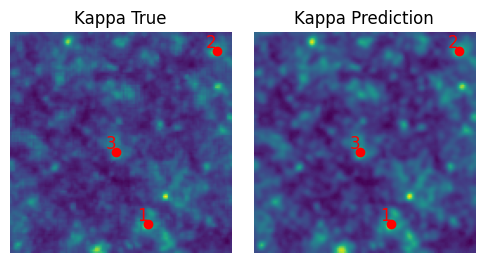

In [81]:
plot_kappa(true_kappa, prediction, show_dpeaks=True)

In [82]:
def compare_kappa(y_true, y_pred):
    plt.hist(y_true.flatten(), bins=100, alpha=0.6, label='True', color='blue', range=(-0.1, 0.2))
    plt.hist(y_pred.flatten(), bins=100, alpha=0.6, label='Pred', color='orange', range=(-0.1, 0.2))
    plt.legend(loc='upper right')
    plt.title('Histograma de Kappa')
    plt.xlabel('Kappa Value')
    plt.ylabel('Frequency')
    plt.show()

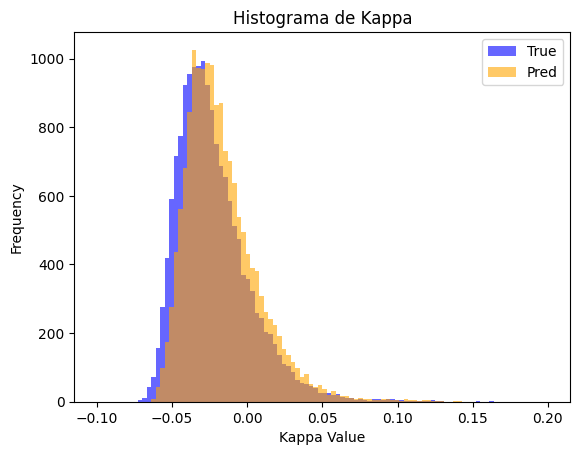

In [83]:
compare_kappa(true_kappa, prediction)

In [84]:
def plot_scatter(y_true, y_pred):
    plt.scatter(y_true.flatten(), y_pred.flatten(), alpha=0.5, s=1)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Kappa')
    plt.ylabel('Predicted Kappa')
    plt.title('Scatter Plot of Predicted vs. True Kappa')
    plt.show()

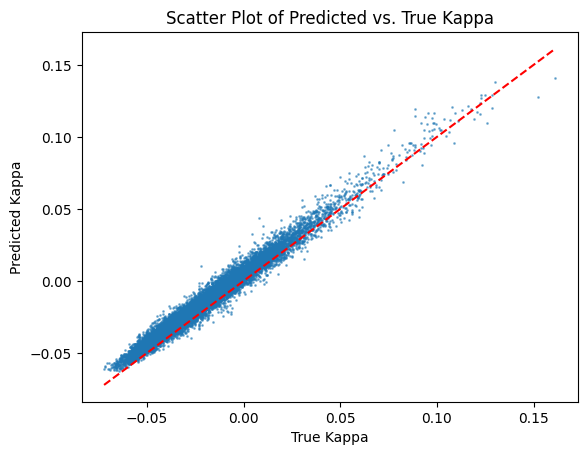

In [85]:
plot_scatter(true_kappa, prediction)

In [91]:
def plot_difference_map(y_true, y_pred):
    difference = y_true.squeeze() - y_pred.squeeze()
    plt.imshow(difference, cmap='RdBu', vmin=-0.05, vmax=0.05)
    plt.colorbar(label='Difference')
    plt.title('Difference Map (True - Predicted)')
    plt.show()

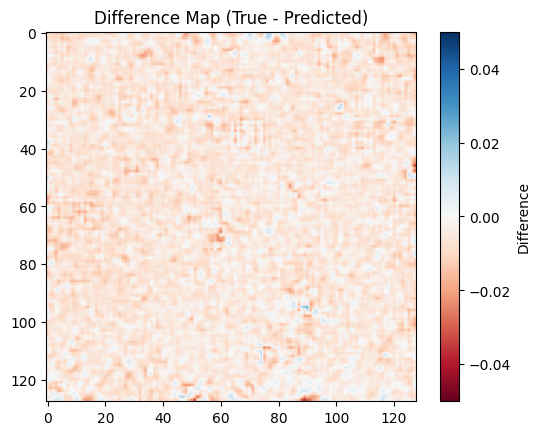

In [92]:
plot_difference_map(true_kappa, prediction)

In [93]:
def plot_metric(metric, history):
    train_met = history['train_' + metric]
    val_met = history['val_' + metric]

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=np.arange(len(train_met)), y=train_met, mode='lines', name='Train'))
    fig.add_trace(go.Scatter(x=np.arange(len(val_met)), y=val_met, mode='lines', name='Validation'))

    fig.update_layout(title=f'{metric} Train vs Validation', xaxis_title='Epoch', yaxis_title=metric)

    fig.show()

In [94]:
metrics= ["dicee", "wmape", "dpeaks", "losses"]
history= checkpoint['history']
for met in metrics:
    plot_metric(met, history)

# Submission

## Setup

In [90]:
TEST_DATASET_PATH = os.path.join('public_test', 'EPSILON')
PREDICTIONS_PATH = os.path.join('losfiducials')
TEST_MODEL_PATH = 'FNO_16_16M_64H_model_50E.pth' # CHANGE IF NEEDED
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# https://drive.google.com/file/d/1UO_4QvJdUxcATFYjdSGtEmcMo1QCBdVx/view?usp=sharing
# test https://drive.google.com/file/d/1MtDSfDjhKnr5nYkSdmsPdlB3bXMVspfg/view?usp=sharing

data_zip = 'public_test.tar.gz'

if Path(data_zip).is_file():
    print("File already exists.")
else:
    import gdown

    file_id = '1UO_4QvJdUxcATFYjdSGtEmcMo1QCBdVx'
    url = f'https://drive.google.com/uc?id={file_id}'

    gdown.download(url, data_zip, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1MtDSfDjhKnr5nYkSdmsPdlB3bXMVspfg
To: /content/public_test.tar.gz
100%|██████████| 10.2M/10.2M [00:00<00:00, 14.3MB/s]


In [ ]:
!mkdir public_test
!tar -xf public_test.tar.gz -C public_test

## Model

In [ ]:
dataset_means, dataset_stds = [7.0964e-06, -1.8894e-05, -2.7692e-05], [0.1863, 0.1860, 0.1838]
dataset_means, dataset_stds = torch.tensor(dataset_means), torch.tensor(dataset_stds)

In [ ]:
class ToTensor(object):
    def __init__(self):
        pass

    def __call__(self, x):
        return torch.from_numpy(x).float()

transform = v2.Compose([
    ToTensor(),
    v2.Normalize(mean=dataset_means, std=dataset_stds),
])

In [ ]:
file_id = '1-9Jlh8r0FmQgDSgu3y-gCa6GUmGtlhd-' #MODEL DRIVE ID CHANGE ACCORDINGLY IF NEEDED

url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(url, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-9Jlh8r0FmQgDSgu3y-gCa6GUmGtlhd-
From (redirected): https://drive.google.com/uc?id=1-9Jlh8r0FmQgDSgu3y-gCa6GUmGtlhd-&confirm=t&uuid=5f6da235-7c24-444c-bf08-1bbd360d31ce
To: /content/UNet_RP_32-512_Normalized_WMSE_model_50E.pth
100%|██████████| 93.2M/93.2M [00:05<00:00, 17.2MB/s]


'UNet_RP_32-512_Normalized_WMSE_model_50E.pth'

In [ ]:
try:
    from neuralop.models import FNO
except:
    !pip install -q neuraloperator wandb torch_harmonics
    from neuralop.models import FNO


model_test = FNO(n_modes=(16, 16), hidden_channels=64, in_channels=3, out_channels=1).to(DEVICE)
#model_test = torch.compile(model_test)

checkpoint = torch.load(TEST_MODEL_PATH, weights_only=False, map_location=DEVICE)
model_test.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## Predict

In [ ]:
def predict_step(model, epsilon, device):
    model.eval()
    with torch.inference_mode():
        epsilon = epsilon.to(device)
        y_hat = model(epsilon)
        y_hat_detached = y_hat.detach()
    return y_hat_detached

In [ ]:
if not os.path.exists(PREDICTIONS_PATH):
    os.makedirs(PREDICTIONS_PATH)

In [ ]:
epsilon_files = os.listdir(TEST_DATASET_PATH)

p_bar = tqdm(epsilon_files, total=len(epsilon_files), desc='')

for epsilon_filepath in p_bar:
    epsilon_data = np.load(os.path.join(TEST_DATASET_PATH, epsilon_filepath))
    epsilon_data_torch = transform(epsilon_data).unsqueeze(0)
    y_hat = predict_step(model_test, epsilon_data_torch, DEVICE)

    y_hat = y_hat.squeeze().cpu().numpy()
    np.save(os.path.join(PREDICTIONS_PATH, epsilon_filepath), y_hat)

100%|██████████| 132/132 [00:01<00:00, 72.37it/s] 


## Plot Predictions

In [ ]:
def plot_prediction(prediction_filepath):
    prediction_image = np.load(prediction_filepath)

    plt.imshow(prediction_image)
    plt.axis('off')
    plt.title('Prediction')
    plt.show()

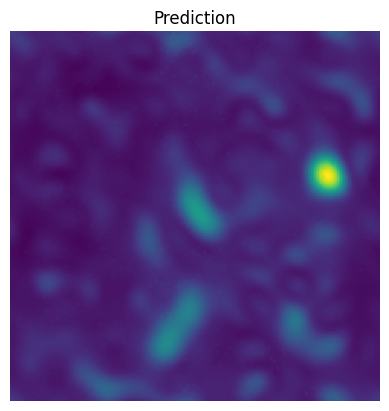

In [ ]:
prediction_filenames = os.listdir(PREDICTIONS_PATH)
prediction_idx = 0

prediction_filepath = os.path.join(PREDICTIONS_PATH, prediction_filenames[prediction_idx])
plot_prediction(prediction_filepath)

## Compress Predictions

In [ ]:
!7z a losfiducials.zip losfiducials


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive:
  0M Scan           1 folder, 132 files, 8667648 bytes (8465 KiB)

Creating archive: losfiducials.zip

Items to compress: 133

  0%     58% 78 + losfiducials/00923_00078.npy                                      
Files read from disk: 132
Archive size: 7634680 bytes (7456 KiB)
Everything is Ok


## Upload to Drive if working in colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

COLAB_PATH = '/content/drive/MyDrive/'
LOCAL_PATH = 'losfiducials.zip'

shutil.copyfile(LOCAL_PATH, os.path.join(COLAB_PATH, LOCAL_PATH))

Mounted at /content/drive


'/content/drive/MyDrive/losfiducials.zip'